# 🔍 Feature Analysis & Engineering for Pirate Pain Classification

This notebook performs comprehensive data analysis to understand:
1. Data quality and distributions
2. Class characteristics
3. Feature importance
4. Temporal patterns
5. Feature correlations
6. Potential new features

**Goal:** Find insights to improve beyond 81% F1 score

In [14]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.signal import find_peaks
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

# Plotting settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✓ Libraries imported")

✓ Libraries imported


## 1. Load Data

In [15]:
# Load data
train_df = pd.read_csv('../data/pirate_pain_train.csv')
labels_df = pd.read_csv('../data/pirate_pain_train_labels.csv')

# Merge labels
train_df = train_df.merge(labels_df, on='sample_index', how='left')

print(f"Total rows: {len(train_df):,}")
print(f"Unique samples: {train_df['sample_index'].nunique()}")
print(f"Time steps per sample: {train_df.groupby('sample_index').size().unique()}")
print(f"\nColumns: {train_df.columns.tolist()}")

Total rows: 105,760
Unique samples: 661
Time steps per sample: [160]

Columns: ['sample_index', 'time', 'pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4', 'n_legs', 'n_hands', 'n_eyes', 'joint_00', 'joint_01', 'joint_02', 'joint_03', 'joint_04', 'joint_05', 'joint_06', 'joint_07', 'joint_08', 'joint_09', 'joint_10', 'joint_11', 'joint_12', 'joint_13', 'joint_14', 'joint_15', 'joint_16', 'joint_17', 'joint_18', 'joint_19', 'joint_20', 'joint_21', 'joint_22', 'joint_23', 'joint_24', 'joint_25', 'joint_26', 'joint_27', 'joint_28', 'joint_29', 'joint_30', 'label']


## 2. Class Distribution Analysis

In [16]:
# Get one row per sample
sample_labels = train_df.groupby('sample_index')['label'].first()

# Class distribution
class_counts = sample_labels.value_counts()
class_pct = sample_labels.value_counts(normalize=True) * 100

print("Class Distribution:")
print("="*50)
for pain_level in ['no_pain', 'low_pain', 'high_pain']:
    if pain_level in class_counts:
        count = class_counts[pain_level]
        pct = class_pct[pain_level]
        print(f"{pain_level:12} : {count:4} samples ({pct:5.2f}%)")

print(f"\nTotal samples: {len(sample_labels)}")

# Check for imbalance
max_ratio = class_counts.max() / class_counts.min()
print(f"\nImbalance ratio: {max_ratio:.2f}:1")
if max_ratio > 2:
    print("⚠️  IMBALANCED - Consider using FocalLoss or class weights")
else:
    print("✓ Relatively balanced")

Class Distribution:
no_pain      :  511 samples (77.31%)
low_pain     :   94 samples (14.22%)
high_pain    :   56 samples ( 8.47%)

Total samples: 661

Imbalance ratio: 9.12:1
⚠️  IMBALANCED - Consider using FocalLoss or class weights


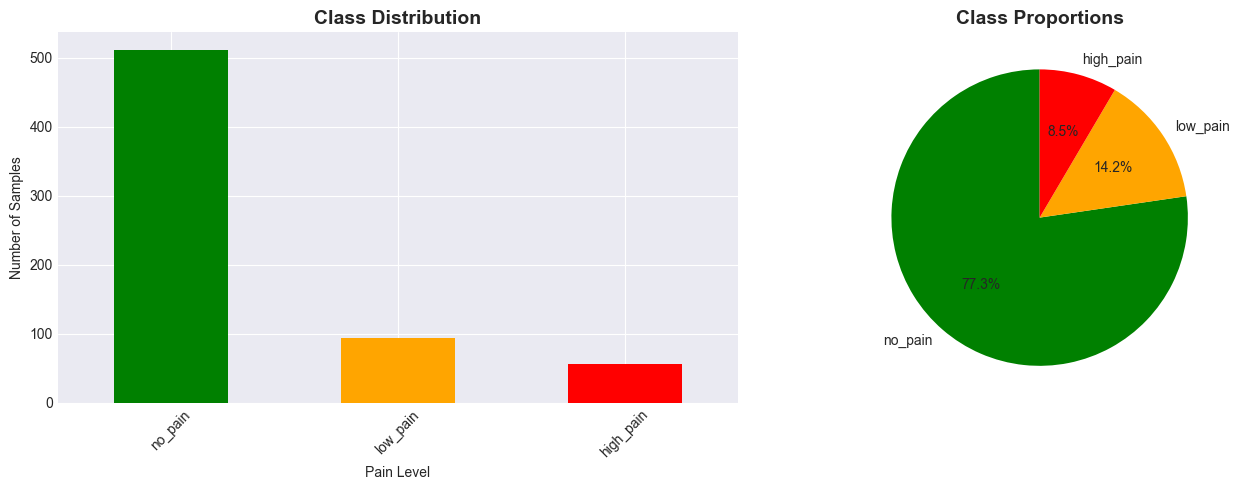

In [17]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
class_counts.plot(kind='bar', ax=axes[0], color=['green', 'orange', 'red'])
axes[0].set_title('Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Pain Level')
axes[0].set_ylabel('Number of Samples')
axes[0].tick_params(axis='x', rotation=45)

# Pie chart
colors = ['green', 'orange', 'red']
axes[1].pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%', 
            colors=colors, startangle=90)
axes[1].set_title('Class Proportions', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 3. Missing Values & Data Quality

In [18]:
# Check for missing values
missing = train_df.isnull().sum()
missing_pct = (missing / len(train_df)) * 100

print("Missing Values:")
print("="*50)
if missing.sum() == 0:
    print("✓ No missing values found!")
else:
    missing_df = pd.DataFrame({
        'Missing': missing[missing > 0],
        'Percentage': missing_pct[missing > 0]
    }).sort_values('Missing', ascending=False)
    print(missing_df)

# Check for duplicate rows
duplicates = train_df.duplicated().sum()
print(f"\nDuplicate rows: {duplicates}")

# Check for constant columns
constant_cols = [col for col in train_df.columns if train_df[col].nunique() == 1]
if constant_cols:
    print(f"\n⚠️  Constant columns (no variance): {constant_cols}")
else:
    print("\n✓ No constant columns")

Missing Values:
✓ No missing values found!

Duplicate rows: 0

⚠️  Constant columns (no variance): ['joint_30']


## 4. Body Part Features Analysis

In [19]:
# Analyze body part columns
body_cols = ['n_legs', 'n_eyes', 'n_hands']

print("Body Part Features:")
print("="*50)

for col in body_cols:
    if col in train_df.columns:
        print(f"\n{col.upper()}:")
        print(train_df[col].value_counts().sort_index())
        print(f"Unique values: {train_df[col].unique()}")

Body Part Features:

N_LEGS:
n_legs
one+peg_leg       960
two            104800
Name: count, dtype: int64
Unique values: ['two' 'one+peg_leg']

N_EYES:
n_eyes
one+eye_patch       960
two              104800
Name: count, dtype: int64
Unique values: ['two' 'one+eye_patch']

N_HANDS:
n_hands
one+hook_hand       960
two              104800
Name: count, dtype: int64
Unique values: ['two' 'one+hook_hand']


In [20]:
# Parse body parts to numeric
def parse_body_parts(value):
    """Parse body part strings like 'one+peg_leg' to count."""
    if isinstance(value, str):
        parts = value.lower().split('+')
        num_str = parts[0]
        if num_str == 'two':
            return 2
        elif num_str == 'one':
            return 1
    return value

# Create parsed versions
for col in body_cols:
    if col in train_df.columns:
        train_df[f'{col}_numeric'] = train_df[col].apply(parse_body_parts)

# Check correlation with pain level
sample_df = train_df.groupby('sample_index').agg({
    'n_legs_numeric': 'first',
    'n_eyes_numeric': 'first',
    'n_hands_numeric': 'first',
    'label': 'first'
}).reset_index()

# Encode pain level
pain_map = {'no_pain': 0, 'low_pain': 1, 'high_pain': 2}
sample_df['pain_numeric'] = sample_df['label'].map(pain_map)

print("\nCorrelation with Pain Level:")
print("="*50)
for col in ['n_legs_numeric', 'n_eyes_numeric', 'n_hands_numeric']:
    corr = sample_df[[col, 'pain_numeric']].corr().iloc[0, 1]
    print(f"{col:20} : {corr:+.4f}")


Correlation with Pain Level:
n_legs_numeric       : +0.0224
n_eyes_numeric       : +0.0224
n_hands_numeric      : +0.0224


## 5. Joint Features Statistics

In [21]:
# Get all joint columns
joint_cols = [col for col in train_df.columns if col.startswith('joint_')]
print(f"Number of joint features: {len(joint_cols)}")
print(f"Joint columns: {joint_cols[:5]} ... (showing first 5)")

# Basic statistics
joint_stats = train_df[joint_cols].describe()
print("\nJoint Features Statistics:")
print(joint_stats)

Number of joint features: 31
Joint columns: ['joint_00', 'joint_01', 'joint_02', 'joint_03', 'joint_04'] ... (showing first 5)

Joint Features Statistics:
            joint_00       joint_01       joint_02       joint_03  \
count  105760.000000  105760.000000  105760.000000  105760.000000   
mean        0.943095       0.916955       0.779296       0.767921   
std         0.202051       0.197608       0.295605       0.300787   
min         0.000000       0.000000       0.001015       0.005403   
25%         0.828277       0.811445       0.568850       0.520020   
50%         1.005126       0.979468       0.909549       0.914834   
75%         1.081039       1.056611       0.995187       0.994324   
max         1.407968       1.334613       1.306046       1.254729   

            joint_04       joint_05       joint_06       joint_07  \
count  105760.000000  105760.000000  105760.000000  105760.000000   
mean        0.709186       0.711306       0.875185       0.837427   
std         0.41

In [22]:
# Check for outliers using IQR method
Q1 = train_df[joint_cols].quantile(0.25)
Q3 = train_df[joint_cols].quantile(0.75)
IQR = Q3 - Q1

# Count outliers per feature
outliers = ((train_df[joint_cols] < (Q1 - 1.5 * IQR)) | 
            (train_df[joint_cols] > (Q3 + 1.5 * IQR))).sum()

outliers_pct = (outliers / len(train_df)) * 100

print("\nOutliers per Feature (IQR method):")
print("="*50)
print(f"Features with >5% outliers: {(outliers_pct > 5).sum()}")
print(f"Features with >10% outliers: {(outliers_pct > 10).sum()}")

if (outliers_pct > 10).any():
    print("\nTop 5 features with most outliers:")
    print(outliers_pct.nlargest(5))


Outliers per Feature (IQR method):
Features with >5% outliers: 19
Features with >10% outliers: 12

Top 5 features with most outliers:
joint_25    15.768722
joint_23    13.993949
joint_24    13.476740
joint_13    13.399206
joint_14    13.070159
dtype: float64


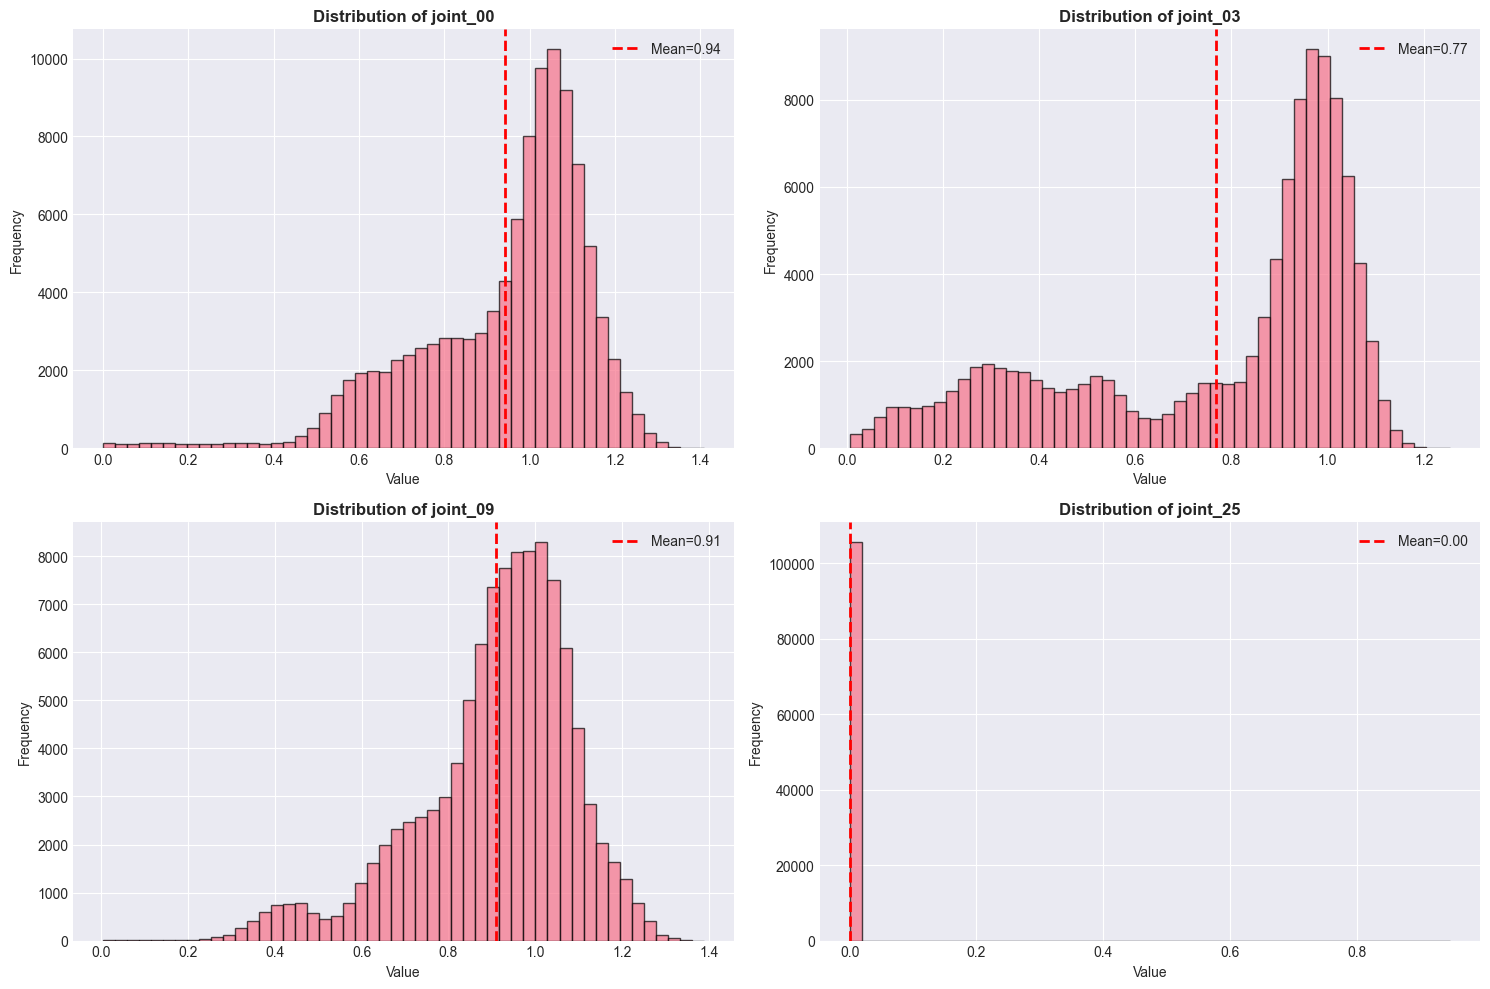

✓ Feature distributions visualized (random sample of 4 joints)


In [27]:
# Visualize feature distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 4 random joint features
sample_joints = np.random.choice(joint_cols, 4, replace=False)
# sample_joints = ["joint_30"]

for idx, col in enumerate(sample_joints):
    ax = axes[idx // 2, idx % 2]
    train_df[col].hist(bins=50, ax=ax, alpha=0.7, edgecolor='black')
    ax.set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    
    # Add mean line
    mean_val = train_df[col].mean()
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean={mean_val:.2f}')
    ax.legend()

plt.tight_layout()
plt.show()

print("✓ Feature distributions visualized (random sample of 4 joints)")

## 6. Temporal Patterns Analysis

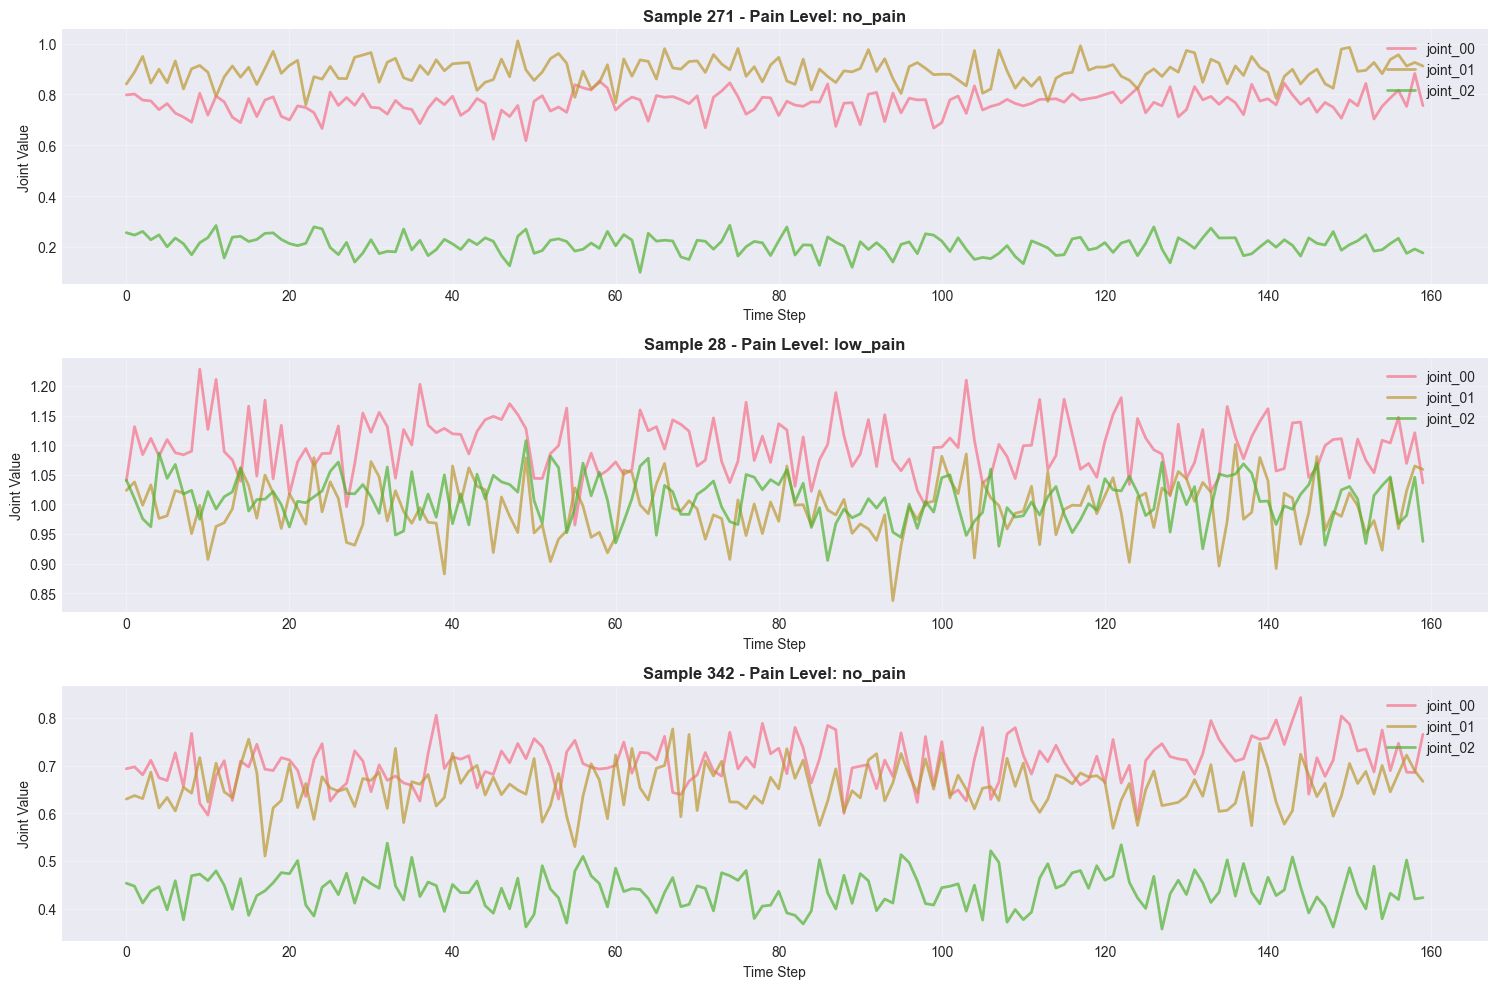

In [25]:
# Analyze time series patterns for a random sample
random_samples = np.random.choice(train_df['sample_index'].unique(), 3, replace=False)

fig, axes = plt.subplots(3, 1, figsize=(15, 10))

for idx, sample_idx in enumerate(random_samples):
    sample_data = train_df[train_df['sample_index'] == sample_idx].sort_values('time')
    pain_level = sample_data['label'].iloc[0]
    
    # Plot first 3 joint features
    for joint_col in joint_cols[:3]:
        axes[idx].plot(sample_data['time'], sample_data[joint_col], 
                      label=joint_col, alpha=0.7, linewidth=2)
    
    axes[idx].set_title(f'Sample {sample_idx} - Pain Level: {pain_level}', 
                       fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Time Step')
    axes[idx].set_ylabel('Joint Value')
    axes[idx].legend(loc='upper right')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Feature Correlations

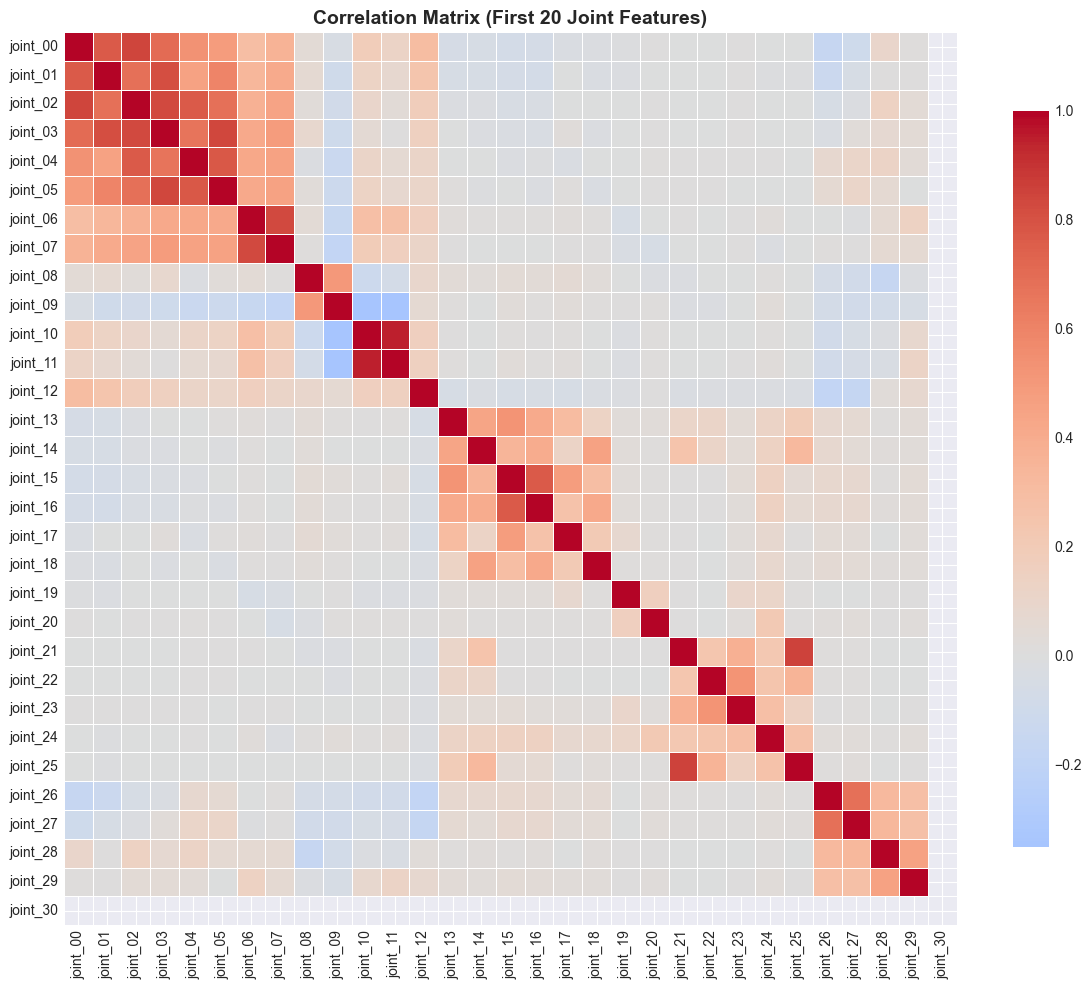


⚠️  Found 1 highly correlated pairs (|r| > 0.9):
  joint_10 <-> joint_11: 0.949
  Consider removing redundant features


In [ ]:
# Compute correlation matrix for joint features (sample for speed)
sample_joint_cols = joint_cols  # First 20 joints
corr_matrix = train_df[sample_joint_cols].corr()

# Visualize
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix (First 20 Joint Features)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Find highly correlated pairs
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.9:
            high_corr_pairs.append((
                corr_matrix.columns[i],
                corr_matrix.columns[j],
                corr_matrix.iloc[i, j]
            ))

if high_corr_pairs:
    print(f"\n⚠️  Found {len(high_corr_pairs)} highly correlated pairs (|r| > 0.9):")
    for feat1, feat2, corr in high_corr_pairs[:5]:
        print(f"  {feat1} <-> {feat2}: {corr:.3f}")
    print("  Consider removing redundant features")
else:
    print("\n✓ No highly correlated features found")

## 8. Per-Class Feature Analysis

In [ ]:
# Compute mean joint values per class
class_means = {}
for pain_level in ['no_pain', 'low_pain', 'high_pain']:
    mask = train_df['label'] == pain_level
    class_means[pain_level] = train_df.loc[mask, joint_cols].mean()

# Convert to DataFrame
class_means_df = pd.DataFrame(class_means)

print("Mean Joint Values per Class:")
print("="*50)
print(class_means_df.head(10))

Mean Joint Values per Class:
           no_pain  low_pain  high_pain
joint_00  0.960049  0.877666   0.898214
joint_01  0.927070  0.896072   0.859703
joint_02  0.779116  0.774578   0.788860
joint_03  0.760371  0.804727   0.775036
joint_04  0.702586  0.765390   0.675064
joint_05  0.704343  0.773851   0.669852
joint_06  0.862851  0.916840   0.917816
joint_07  0.823186  0.884605   0.888184
joint_08  0.847659  0.853314   0.862255
joint_09  0.916542  0.889231   0.879908


In [ ]:
# Find features with highest class separation
class_std = class_means_df.std(axis=1)
top_discriminative = class_std.nlargest(10)

print("\nTop 10 Most Discriminative Features (highest variance across classes):")
print("="*50)
for feat, std_val in top_discriminative.items():
    print(f"{feat:20} : {std_val:.4f}")
    print(f"  no_pain: {class_means_df.loc[feat, 'no_pain']:.4f}")
    print(f"  low_pain: {class_means_df.loc[feat, 'low_pain']:.4f}")
    print(f"  high_pain: {class_means_df.loc[feat, 'high_pain']:.4f}")
    print()


Top 10 Most Discriminative Features (highest variance across classes):
joint_10             : 0.0590
  no_pain: 0.7022
  low_pain: 0.7092
  high_pain: 0.6037

joint_05             : 0.0530
  no_pain: 0.7043
  low_pain: 0.7739
  high_pain: 0.6699

joint_11             : 0.0488
  no_pain: 0.6959
  low_pain: 0.7084
  high_pain: 0.6183

joint_04             : 0.0463
  no_pain: 0.7026
  low_pain: 0.7654
  high_pain: 0.6751

joint_00             : 0.0429
  no_pain: 0.9600
  low_pain: 0.8777
  high_pain: 0.8982

joint_07             : 0.0365
  no_pain: 0.8232
  low_pain: 0.8846
  high_pain: 0.8882

joint_01             : 0.0337
  no_pain: 0.9271
  low_pain: 0.8961
  high_pain: 0.8597

joint_12             : 0.0329
  no_pain: 1.0509
  low_pain: 1.0107
  high_pain: 1.0760

joint_06             : 0.0315
  no_pain: 0.8629
  low_pain: 0.9168
  high_pain: 0.9178

joint_27             : 0.0265
  no_pain: 0.0479
  low_pain: 0.0999
  high_pain: 0.0828



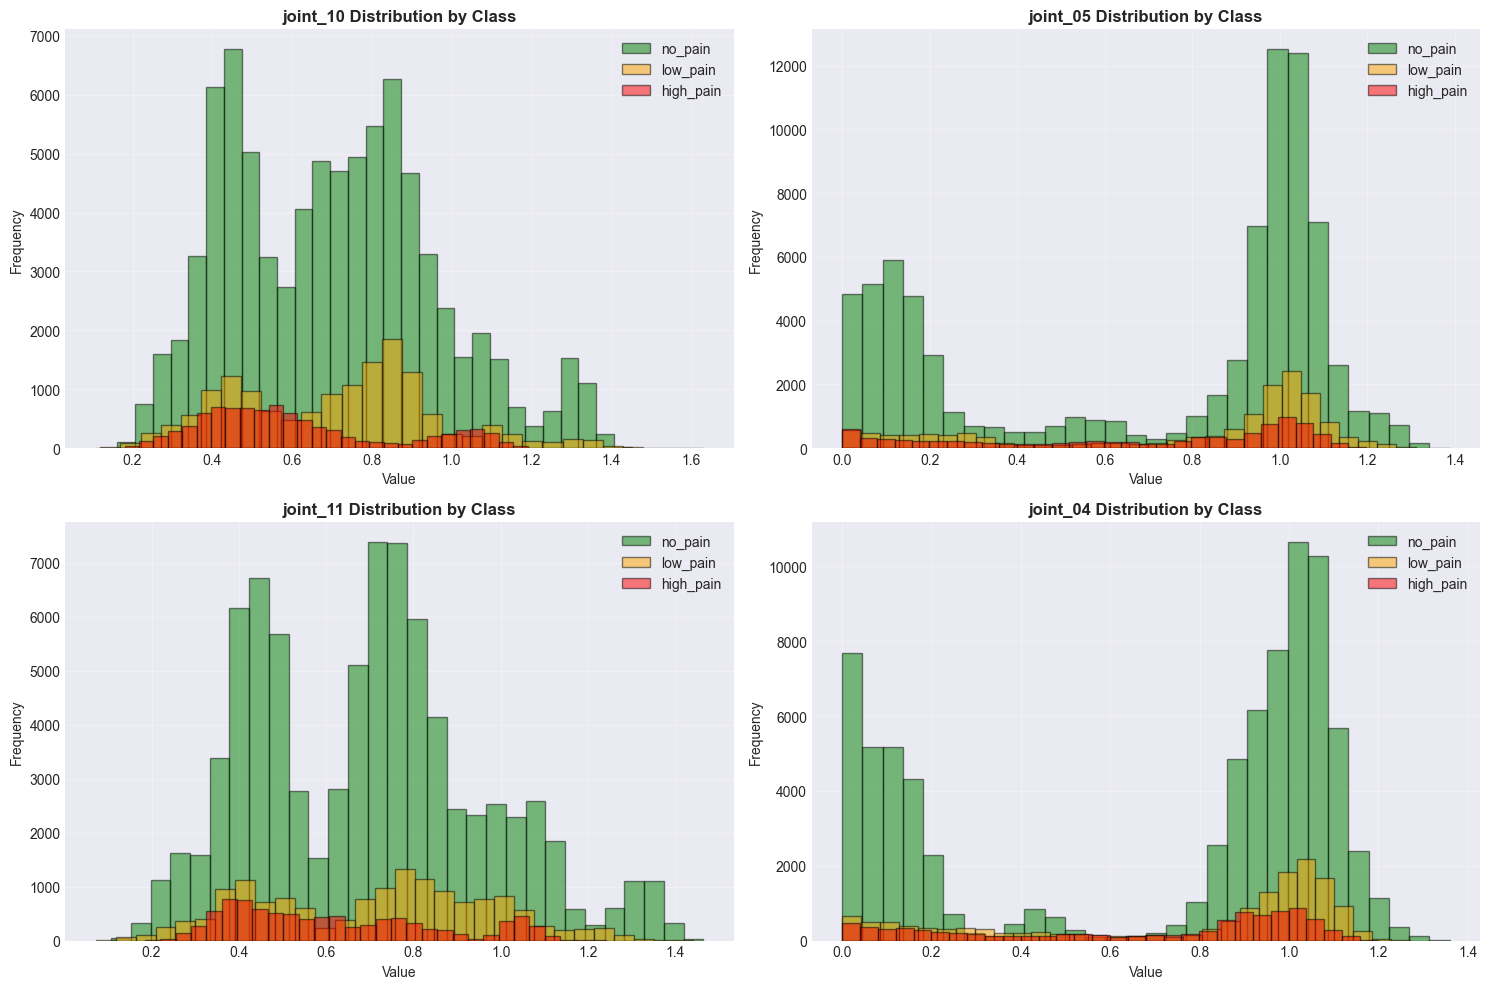

In [ ]:
# Visualize top discriminative features
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for idx, feat in enumerate(top_discriminative.index[:4]):
    for pain_level, color in zip(['no_pain', 'low_pain', 'high_pain'], 
                                  ['green', 'orange', 'red']):
        mask = train_df['label'] == pain_level
        axes[idx].hist(train_df.loc[mask, feat], bins=30, alpha=0.5, 
                      label=pain_level, color=color, edgecolor='black')
    
    axes[idx].set_title(f'{feat} Distribution by Class', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Value')
    axes[idx].set_ylabel('Frequency')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Feature Importance (Random Forest)

In [ ]:
# Prepare data for Random Forest
# Aggregate time series features (mean, std, min, max per sample)
print("Computing aggregate features per sample...")

sample_features = []
sample_labels = []

for sample_idx in train_df['sample_index'].unique():
    sample_data = train_df[train_df['sample_index'] == sample_idx]
    
    # Aggregate stats
    feat_dict = {}
    for col in joint_cols[:10]:  # Use first 10 joints for speed
        feat_dict[f'{col}_mean'] = sample_data[col].mean()
        feat_dict[f'{col}_std'] = sample_data[col].std()
        feat_dict[f'{col}_min'] = sample_data[col].min()
        feat_dict[f'{col}_max'] = sample_data[col].max()
    
    sample_features.append(feat_dict)
    sample_labels.append(sample_data['label'].iloc[0])

X_rf = pd.DataFrame(sample_features)
y_rf = pd.Series(sample_labels)

print(f"✓ Created {len(X_rf)} samples with {len(X_rf.columns)} features")

Computing aggregate features per sample...
✓ Created 661 samples with 40 features
✓ Created 661 samples with 40 features


In [ ]:
# Train Random Forest for feature importance
print("Training Random Forest...")
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X_rf, y_rf)

# Get feature importances
importances = pd.Series(rf.feature_importances_, index=X_rf.columns)
top_features = importances.nlargest(20)

print("\nTop 20 Most Important Features:")
print("="*50)
for feat, imp in top_features.items():
    print(f"{feat:30} : {imp:.4f}")

Training Random Forest...

Top 20 Most Important Features:
joint_02_std                   : 0.0777
joint_03_std                   : 0.0616
joint_04_std                   : 0.0494
joint_05_std                   : 0.0450
joint_00_std                   : 0.0347
joint_01_std                   : 0.0326
joint_05_mean                  : 0.0321
joint_00_mean                  : 0.0318
joint_01_min                   : 0.0300
joint_03_mean                  : 0.0285
joint_02_max                   : 0.0265
joint_01_mean                  : 0.0263
joint_00_max                   : 0.0255
joint_04_mean                  : 0.0252
joint_03_min                   : 0.0235
joint_05_min                   : 0.0232
joint_00_min                   : 0.0231
joint_02_min                   : 0.0227
joint_02_mean                  : 0.0224
joint_04_min                   : 0.0223


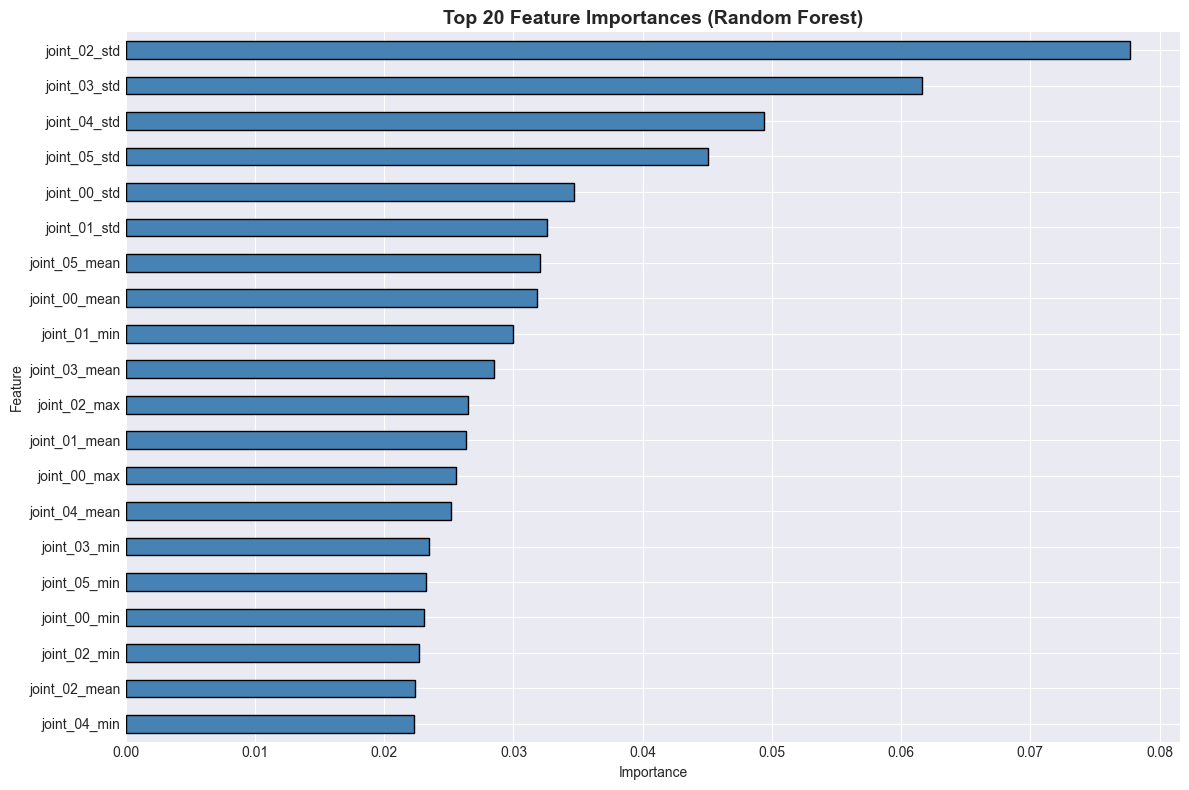


Random Forest Accuracy: 0.9773


In [ ]:
# Visualize feature importances
plt.figure(figsize=(12, 8))
top_features.sort_values().plot(kind='barh', color='steelblue', edgecolor='black')
plt.title('Top 20 Feature Importances (Random Forest)', fontsize=14, fontweight='bold')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print(f"\nRandom Forest Accuracy: {rf.score(X_rf, y_rf):.4f}")

## 10. Variance & Signal-to-Noise Analysis

In [ ]:
# Compute variance per feature
feature_variance = train_df[joint_cols].var().sort_values(ascending=False)

print("Feature Variance Analysis:")
print("="*50)
print(f"High variance features (>1.0): {(feature_variance > 1.0).sum()}")
print(f"Low variance features (<0.01): {(feature_variance < 0.01).sum()}")

if (feature_variance < 0.01).any():
    print("\n⚠️  Low variance features (consider removing):")
    low_var_features = feature_variance[feature_variance < 0.01]
    print(low_var_features.head(50))

# Visualize variance distribution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
feature_variance.plot(kind='hist', bins=50, edgecolor='black')
plt.title('Distribution of Feature Variances', fontsize=12, fontweight='bold')
plt.xlabel('Variance')
plt.ylabel('Number of Features')
plt.yscale('log')

plt.subplot(1, 2, 2)
feature_variance.nlargest(20).sort_values().plot(kind='barh', color='coral', edgecolor='black')
plt.title('Top 20 Highest Variance Features', fontsize=12, fontweight='bold')
plt.xlabel('Variance')

plt.tight_layout()
plt.show()

Feature Variance Analysis:
High variance features (>1.0): 0
Low variance features (<0.01): 18

⚠️  Low variance features (consider removing):
joint_27    6.371117e-03
joint_29    5.270355e-03
joint_28    3.693392e-03
joint_26    3.635220e-03
joint_20    4.174296e-05
joint_22    2.994545e-05
joint_18    2.486834e-05
joint_21    2.474561e-05
joint_17    1.921160e-05
joint_19    1.515143e-05
joint_25    1.027925e-05
joint_16    2.653107e-06
joint_14    2.195316e-06
joint_15    1.658092e-06
joint_23    1.526336e-06
joint_13    1.445790e-06
joint_24    1.650727e-07
joint_30    0.000000e+00
dtype: float64


AttributeError: 'Series' object has no attribute 'columns'

## 11. PCA Analysis

In [ ]:
# Perform PCA on joint features
print("Performing PCA...")

# Standardize features first
scaler = StandardScaler()
X_scaled = scaler.fit_transform(train_df[joint_cols])

# PCA
pca = PCA(n_components=20)
X_pca = pca.fit_transform(X_scaled)

# Explained variance
explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

print(f"\nVariance explained by first 20 components: {cumulative_var[-1]:.4f}")
print(f"Components needed for 90% variance: {np.argmax(cumulative_var >= 0.9) + 1}")
print(f"Components needed for 95% variance: {np.argmax(cumulative_var >= 0.95) + 1}")

Performing PCA...

Variance explained by first 20 components: 0.9411
Components needed for 90% variance: 18
Components needed for 95% variance: 1


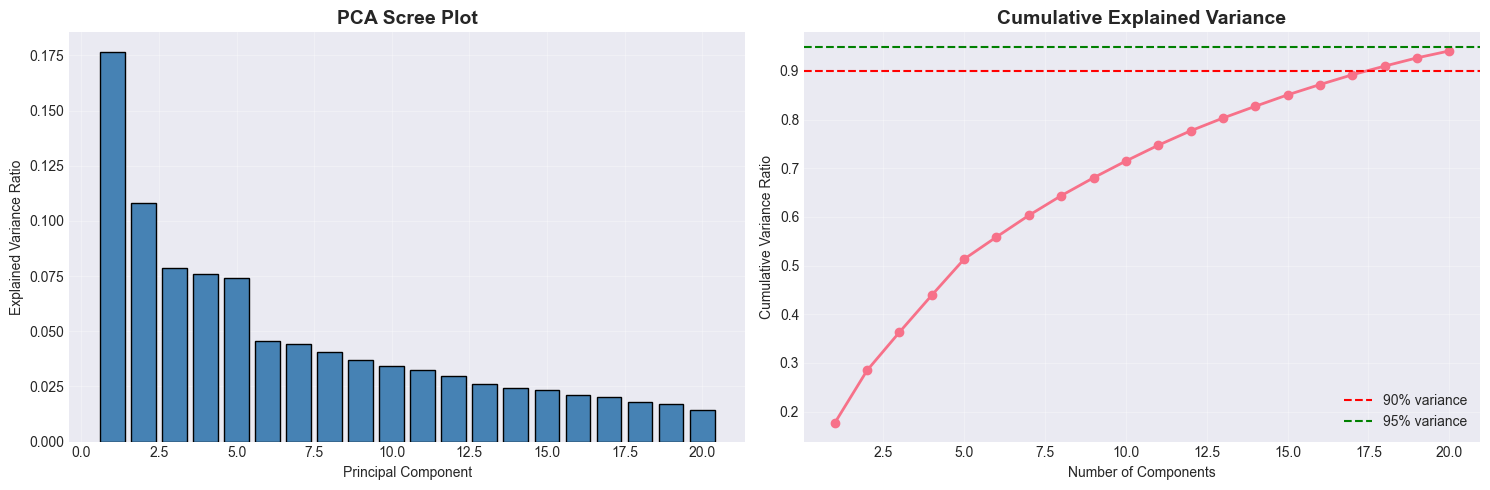

In [ ]:
# Visualize PCA results
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Scree plot
axes[0].bar(range(1, 21), explained_var, color='steelblue', edgecolor='black')
axes[0].set_title('PCA Scree Plot', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].grid(True, alpha=0.3)

# Cumulative variance
axes[1].plot(range(1, 21), cumulative_var, marker='o', linewidth=2, markersize=6)
axes[1].axhline(y=0.9, color='r', linestyle='--', label='90% variance')
axes[1].axhline(y=0.95, color='g', linestyle='--', label='95% variance')
axes[1].set_title('Cumulative Explained Variance', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Variance Ratio')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 12. Summary & Recommendations

### Key Findings:
1. **Class Balance**: Check if dataset is imbalanced
2. **Data Quality**: Missing values, outliers, duplicates
3. **Feature Variance**: High/low variance features
4. **Correlations**: Redundant features to remove
5. **Discriminative Features**: Which features separate classes best
6. **Feature Importance**: Random Forest ranking
7. **Dimensionality**: PCA suggests optimal number of features

### Potential Improvements:
- Remove low-variance features
- Remove highly correlated features
- Focus on most discriminative features
- Engineer new temporal features (next section)
- Handle class imbalance if present
- Consider PCA or feature selection

In [ ]:
# Save analysis results
analysis_results = {
    'n_samples': len(train_df['sample_index'].unique()),
    'n_features': len(joint_cols),
    'class_distribution': class_counts.to_dict(),
    'imbalance_ratio': max_ratio,
    'top_discriminative_features': top_discriminative.to_dict(),
    'low_variance_features': feature_variance[feature_variance < 0.01].index.tolist(),
    'pca_components_for_90pct': int(np.argmax(cumulative_var >= 0.9) + 1),
}

import json
with open('../feature_analysis_results.json', 'w') as f:
    json.dump(analysis_results, f, indent=2)

print("✅ Analysis complete! Results saved to feature_analysis_results.json")
print("\nNext steps: Run feature engineering notebook to create new features!")

✅ Analysis complete! Results saved to feature_analysis_results.json

Next steps: Run feature engineering notebook to create new features!
